In [1]:
from collections import Counter
import os
import re

from matplotlib import font_manager, rc
from imutils.paths import list_files
import matplotlib.pyplot as plt
import geopandas as gpd
import requests as req
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
ROOT_PATH = '/'.join(os.getcwd().split('/')[:-2])
DATA_PATH = f'{ROOT_PATH}/doodle/data/geo'
FONT_PATH = f'{ROOT_PATH}/doodle/data/fonts/NanumMyeongjo.ttf'

In [3]:
font = font_manager.FontProperties(fname = FONT_PATH).get_name()
rc('font', family = font)

In [4]:
def read_shp(path, region = 'dong'): 
    
    if   region ==   'dong': name_col = 'EMD_NM'
    elif region ==  'towns': name_col = 'RI_NM'
    elif region == 'cities': name_col = 'SGG_NM'
    
    return gpd.read_file(path, encoding = 'euc-kr')[name_col]


def clear_str(string):
    
    string = re.compile('[0-9*]가').sub('', string)
    string = re.compile('[^가-힣*]').sub('', string)[:-1]
    string = string.replace('특별자치', '')
    return ''.join(string.split('시'))


def all_sectors(files, kind = 'partial'):
    
    sectors     = ''
    num_sectors  = {file.split(os.path.sep)[-2] : 0 for file in files}
    
    for file in files:
        
        region   = file.split(os.path.sep)[-3]
        province = file.split(os.path.sep)[-2]
        
        sec      = read_shp(file, region = region).dropna()
        sec      = set([clear_str(s) for s in sec])
        sectors += ''.join(sec) 
        
        num_sectors[province] = len(sec) if kind != 'all' else \
                                num_sectors[province] + len(sec)
    
    return sectors, num_sectors


def most_char_province(files, most_common):
    
    num_province = {}
    for file in files:
        
        region = file.split(os.path.sep)[-3]
        province = file.split(os.path.sep)[-2]
        
        num_province[province] = [0 for _ in most_common]
        
        sec = read_shp(file, region = region).dropna()
        sec = set([clear_str(s) for s in sec])
        sec = ''.join(sec)
        
        for idx, most in enumerate(most_common):
            
            num_province[province][idx] += sec.count(most[0])
        
    return num_province


def make_dirs(region = 'dong'):
    
    
    dir_names = ['BS', 'CB', 'CN', 'DG', 'DJ', 'IC', 'JB',
                'JJ','JN', 'KB', 'KG', 'KJ', 'KN', 'KW',
                'SJ', 'SU', 'US']
    
    [os.makedirs(f'{DATA_PATH}/{region}/{dir_name}', exist_ok = True) 
     for dir_name in dir_names]
    

def ratio_calculator(string, all_cnt):
    
    string_cnt = Counter(string)
    top_20p    = string_cnt.most_common(len(all_cnt) // 5)
    
    sum_top20p = sum([top[1] for top in top_20p])
    sum_allcnt = sum([all for all in all_cnt.values()])
    
    sum_top20p / sum_allcnt, sum_top20p, sum_allcnt 


def show_figure(data, is_percentage = False):
    
    if isinstance(data, pd.DataFrame):
        
        plt.figure(figsize = (16, 5))
        
        if is_percentage:
            sns.heatmap(data.div(data.sum(axis = 1), axis = 0),
                        cmap = 'BuPu', linewidths = .8, annot = True, fmt = '.2%')
            
        else:
            sns.heatmap(data, cmap = 'BuPu', annot = True, fmt = 'g')
            
            
    else:
        plt.figure(figsize = (30, 10))
        plt.bar(data.keys(), data.values())
        

In [5]:
make_dirs()
make_dirs(region = 'cities')
make_dirs(region =  'towns')

In [6]:
files               = [path for path in list_files(DATA_PATH) if path.split('.')[-1] == 'shp']
string, num_sectors = all_sectors(files, kind = 'all')
num_sectors

{'CN': 1812,
 'CB': 1403,
 'BS': 211,
 'DG': 274,
 'KB': 2549,
 'KW': 1286,
 'SJ': 146,
 'JB': 1517,
 'IC': 262,
 'JJ': 192,
 'KN': 1900,
 'US': 203,
 'DJ': 176,
 'JN': 2163,
 'KJ': 190,
 'KG': 1916,
 'SU': 401}

In [7]:
all_cnt         = sorted(Counter(string).items(), key = lambda x: x[1], reverse = True)
most_common_all = all_cnt[:10]
all_cnt         = dict(all_cnt)

In [8]:
most_all    = most_char_province(files, most_common_all)
indexes     = [m[0] for m in most_common_all]
most_all_df = pd.DataFrame(most_all, index = indexes)
most_all_df

,CN,CB,BS,DG,KB,KW,SJ,JB,IC,JJ,KN,US,DJ,JN,KJ,KG,SU
산,28,16,4,15,38,19,1,35,7,1,28,7,10,35,21,47,14
곡,12,8,3,6,18,10,1,4,4,0,24,4,3,13,8,29,11
동,6,9,7,9,23,14,2,15,3,1,25,4,0,15,5,22,7
천,16,12,8,9,25,13,0,12,2,2,18,4,3,10,3,23,11
대,12,7,11,12,18,6,1,5,2,2,28,2,10,15,7,23,9
신,16,11,6,10,16,7,0,16,5,1,14,4,12,9,8,25,23
정,9,9,5,3,14,9,2,16,2,2,16,7,11,7,7,24,13
성,24,18,4,12,24,9,1,17,2,1,21,5,8,10,2,13,7
평,2,8,4,5,16,10,1,6,4,4,13,1,6,10,2,18,5
도,3,2,0,4,13,8,1,9,8,17,11,0,5,17,7,14,10


In [9]:
indexes     = [m[0] for m in most_common_all]
most_all_df = pd.DataFrame(most_all, index = indexes)
most_all_df

,CN,CB,BS,DG,KB,KW,SJ,JB,IC,JJ,KN,US,DJ,JN,KJ,KG,SU
산,28,16,4,15,38,19,1,35,7,1,28,7,10,35,21,47,14
곡,12,8,3,6,18,10,1,4,4,0,24,4,3,13,8,29,11
동,6,9,7,9,23,14,2,15,3,1,25,4,0,15,5,22,7
천,16,12,8,9,25,13,0,12,2,2,18,4,3,10,3,23,11
대,12,7,11,12,18,6,1,5,2,2,28,2,10,15,7,23,9
신,16,11,6,10,16,7,0,16,5,1,14,4,12,9,8,25,23
정,9,9,5,3,14,9,2,16,2,2,16,7,11,7,7,24,13
성,24,18,4,12,24,9,1,17,2,1,21,5,8,10,2,13,7
평,2,8,4,5,16,10,1,6,4,4,13,1,6,10,2,18,5
도,3,2,0,4,13,8,1,9,8,17,11,0,5,17,7,14,10


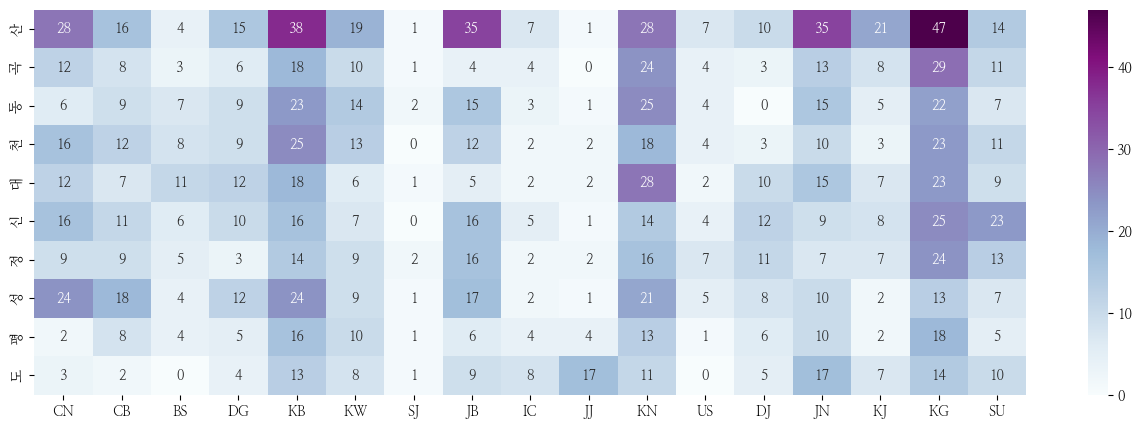

In [10]:
show_figure(most_all_df)

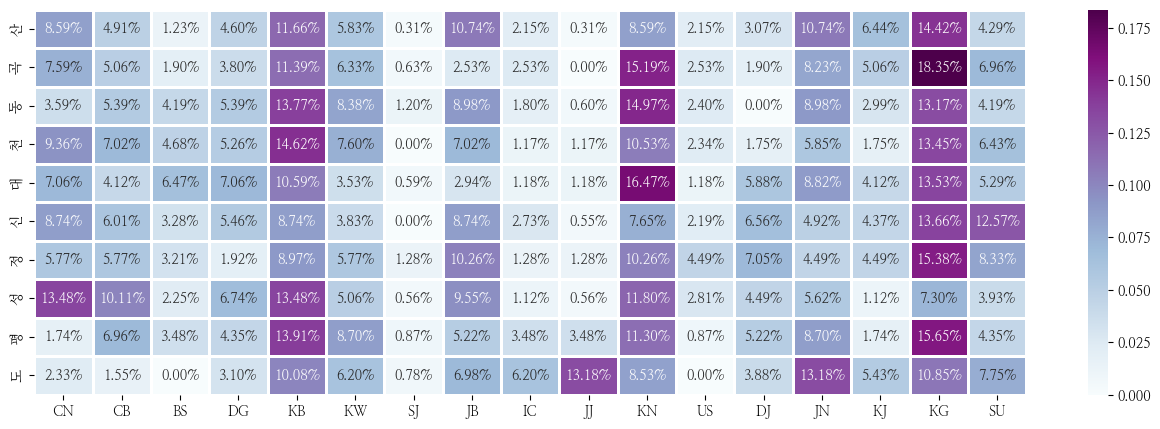

In [11]:
show_figure(most_all_df, is_percentage = True)

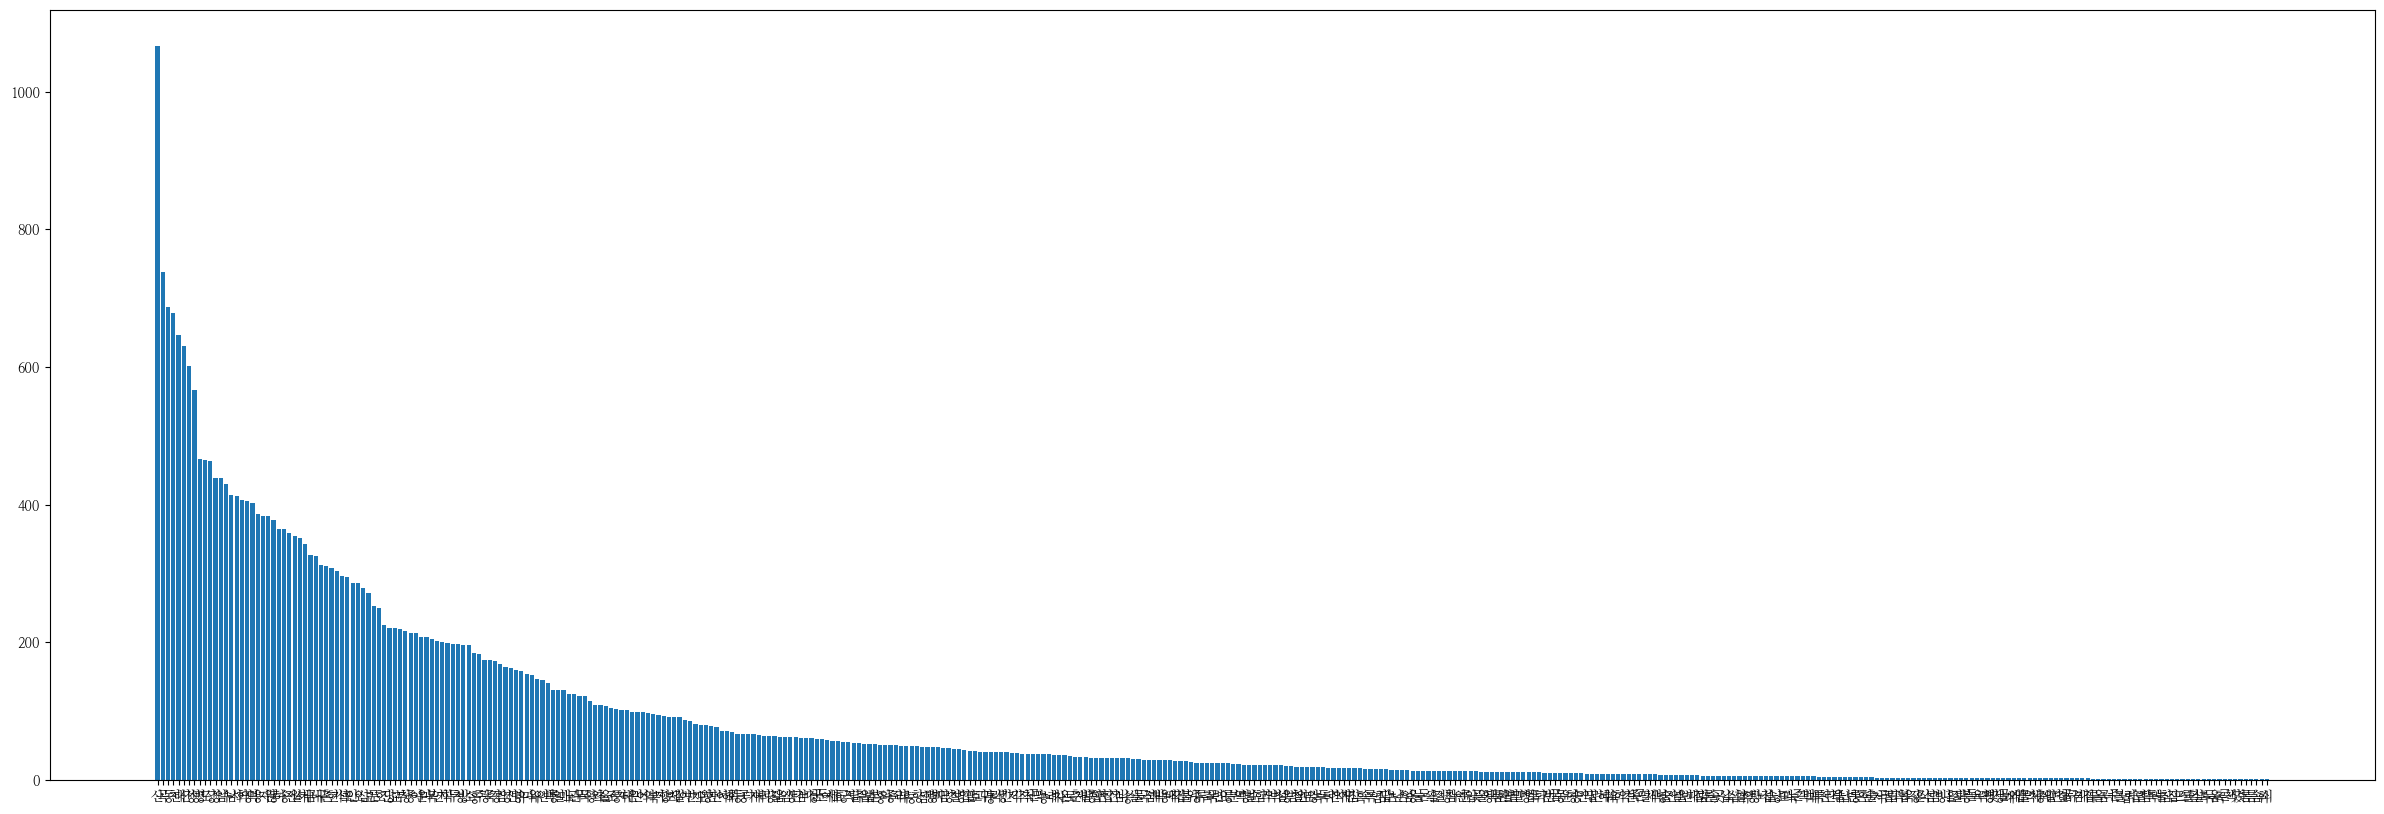

In [12]:
show_figure(all_cnt)

In [13]:
ratio, sum_all20p, sum_allall = ratio_calculator(string, all_cnt)
f'{ratio * 100:.3f} %'

'74.763 %'

In [14]:
sum_all20p, sum_allall, 0.8 * sum_allall 

(24731, 33079, 26463.2)

In [15]:
files            = [path for path in list_files(f'{DATA_PATH}/dong') if path.split('.')[-1] == 'shp']
dongs, num_dongs = all_sectors(files)
dong_cnt         = sorted(Counter(dongs).items(), key = lambda x: x[1], reverse = True)
most_dong        = dong_cnt[:10]
dong_cnt         = dict(dong_cnt)

num_dongs, most_dong

({'DJ': 171,
  'BS': 133,
  'CB': 231,
  'CN': 272,
  'DG': 176,
  'JB': 347,
  'IC': 131,
  'JJ': 73,
  'JN': 376,
  'KB': 500,
  'KG': 670,
  'KN': 474,
  'KJ': 185,
  'KW': 269,
  'SJ': 33,
  'SU': 357,
  'US': 84},
 [('산', 326),
  ('신', 183),
  ('성', 178),
  ('남', 176),
  ('천', 171),
  ('대', 170),
  ('동', 167),
  ('곡', 158),
  ('정', 156),
  ('서', 134)])

In [16]:
most_dong_province = most_char_province(files, most_dong)
indexes            = [d[0] for d in most_dong] 
most_dong_df       = pd.DataFrame(most_dong_province, index = indexes)
most_dong_df

,DJ,BS,CB,CN,DG,JB,IC,JJ,JN,KB,KG,KN,KJ,KW,SJ,SU,US
산,10,4,16,28,15,35,7,1,35,38,47,28,21,19,1,14,7
신,12,6,11,16,10,16,5,1,9,16,25,14,8,7,0,23,4
성,8,4,18,24,12,17,2,1,10,24,13,21,2,9,1,7,5
남,3,6,13,11,4,9,5,3,14,26,20,24,9,13,1,11,4
천,3,8,12,16,9,12,2,2,10,25,23,18,3,13,0,11,4
대,10,11,7,12,12,5,2,2,15,18,23,28,7,6,1,9,2
동,0,7,9,6,9,15,3,1,15,23,22,25,5,14,2,7,4
곡,3,3,8,12,6,4,4,0,13,18,29,24,8,10,1,11,4
정,11,5,9,9,3,16,2,2,7,14,24,16,7,9,2,13,7
서,1,3,8,5,9,16,5,3,13,17,17,14,4,5,1,8,5


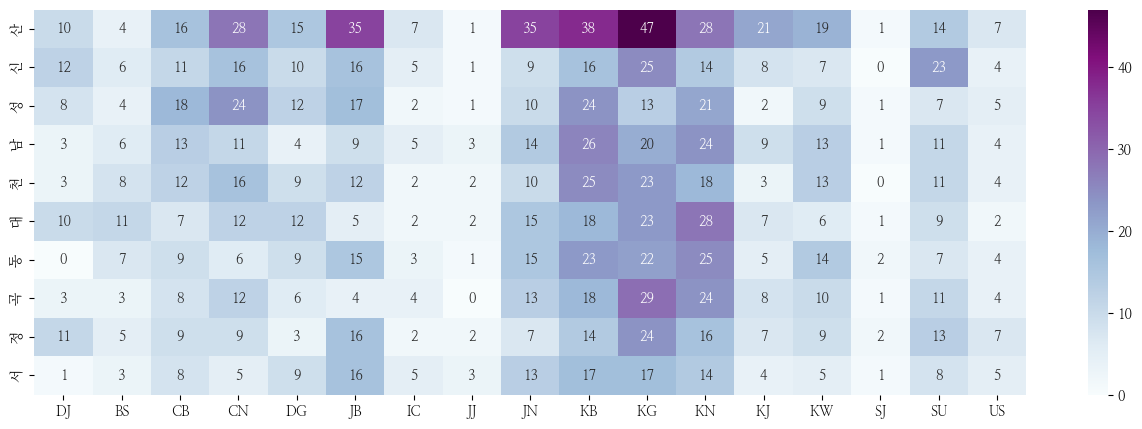

In [17]:
show_figure(most_dong_df)

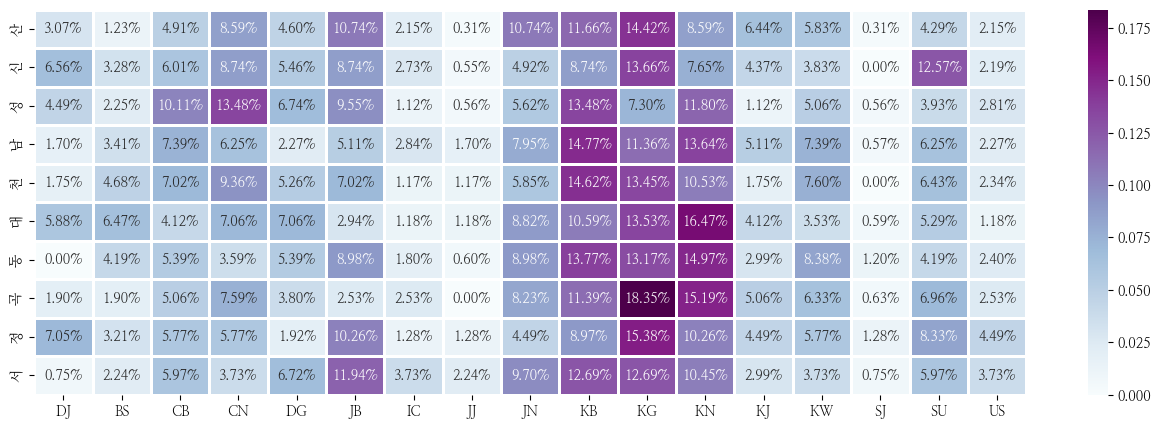

In [18]:
show_figure(most_dong_df, is_percentage = True)

In [19]:
ratio, sum_dong20p, sum_dongall = ratio_calculator(dongs, dong_cnt)
f'{ratio * 100:.3f} %'

'71.887 %'

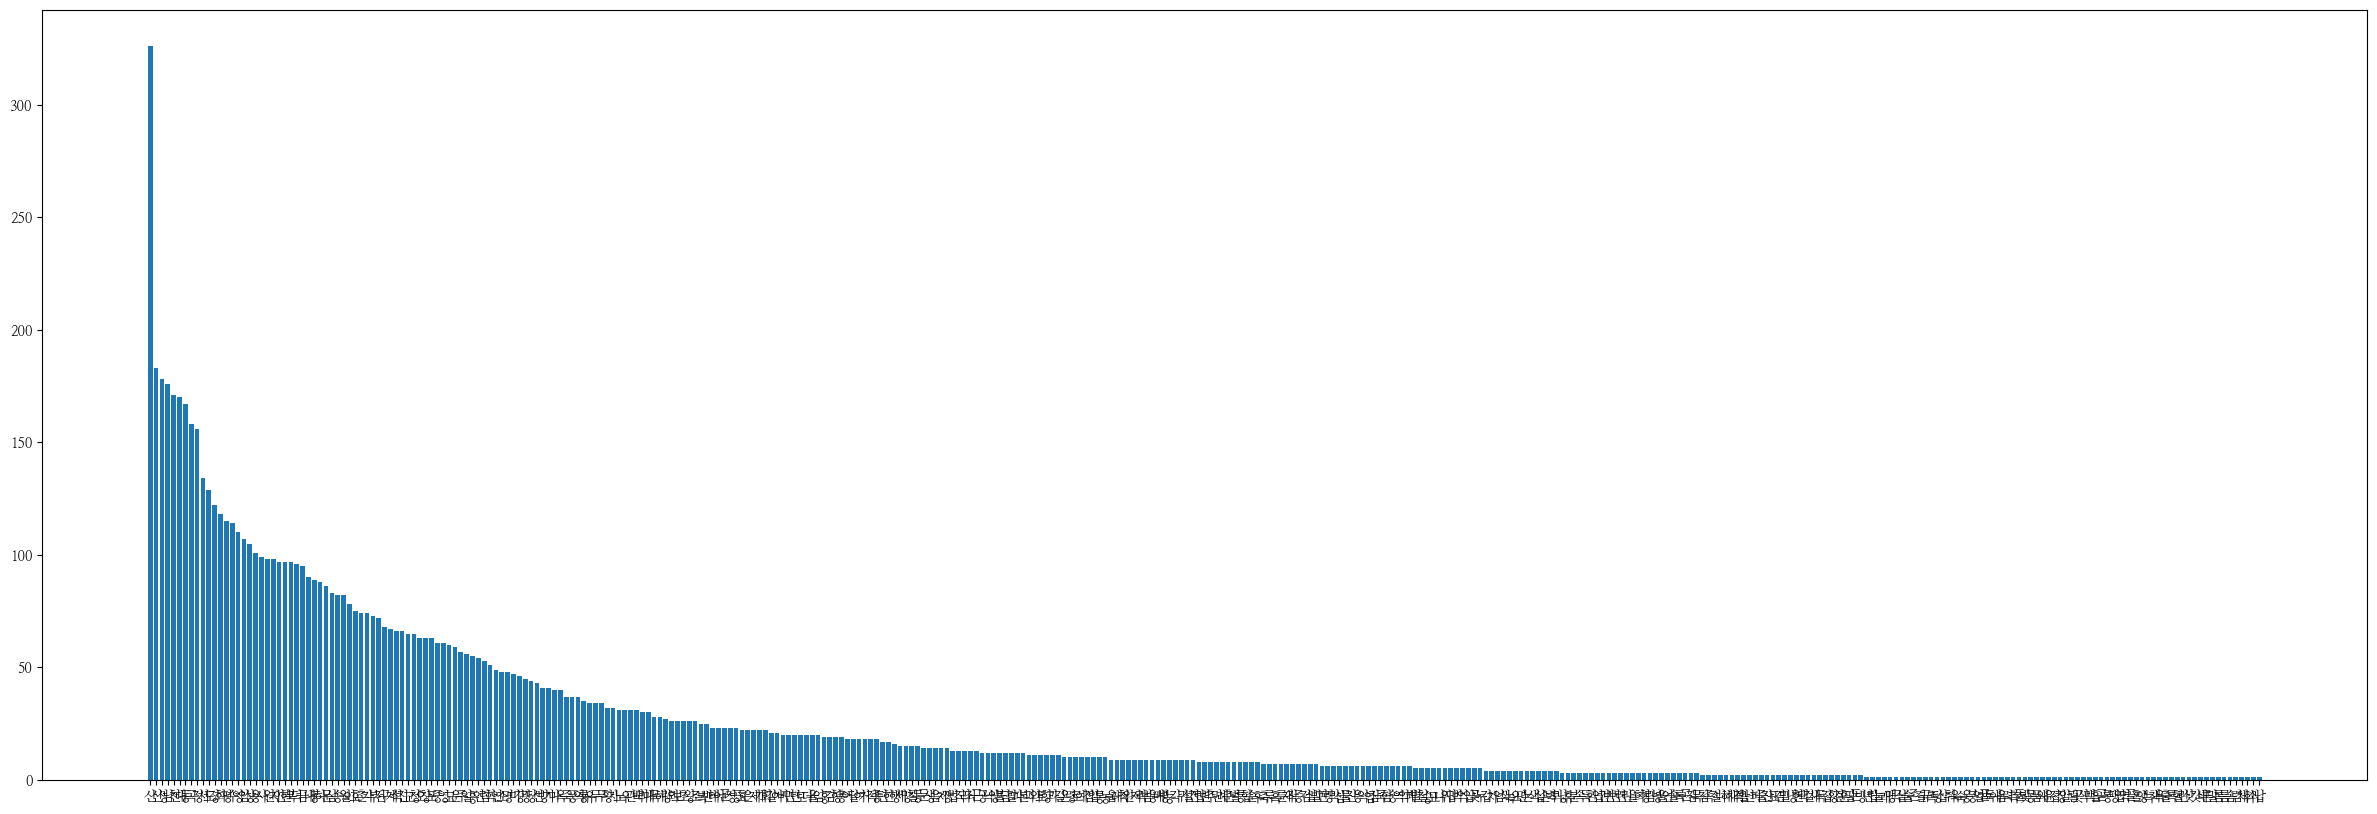

In [20]:
show_figure(dong_cnt)

In [21]:
sum_dong20p, sum_dongall, 0.8 * sum_dongall

(6385, 8882, 7105.6)

In [22]:
files              = [path for path in list_files(f'{DATA_PATH}/cities') if path.split('.')[-1] == 'shp']
cities, num_cities = all_sectors(files)

not_uniques = [
               '천안', '청주', '안양', '고양', 
               '성남', '용인', '수원', '성남', 
               '안산', '창원'
              ]
for not_unique in not_uniques: 
    cities = cities.replace(not_unique, '') + not_unique
    
cities_cnt = sorted(Counter(cities).items(), 
                    key = lambda x: x[1], reverse = True)

most_cities = cities_cnt[:10]
cities_cnt = dict(cities_cnt)
num_cities, most_cities

({'CN': 16,
  'CB': 15,
  'BS': 16,
  'DG': 8,
  'KB': 24,
  'KW': 18,
  'SJ': 1,
  'JB': 15,
  'IC': 10,
  'JJ': 2,
  'KN': 22,
  'US': 5,
  'DJ': 5,
  'JN': 22,
  'KJ': 5,
  'KG': 42,
  'SU': 25},
 [('산', 22),
  ('주', 21),
  ('천', 21),
  ('양', 20),
  ('동', 20),
  ('성', 19),
  ('서', 16),
  ('안', 14),
  ('남', 14),
  ('영', 13)])

In [23]:
most_city_province = most_char_province(files, most_cities)
indexes            = [c[0] for c in most_cities] 
most_city_df       = pd.DataFrame(most_city_province, index = indexes)
most_city_df

,CN,CB,BS,DG,KB,KW,SJ,JB,IC,JJ,KN,US,DJ,JN,KJ,KG,SU
산,5,1,1,0,1,0,0,3,0,0,5,0,0,0,1,5,1
주,1,4,0,0,4,1,0,4,0,1,1,1,0,1,0,5,0
천,3,3,0,0,3,3,0,0,0,0,2,0,0,1,0,6,2
양,1,1,0,0,1,3,0,0,1,0,3,0,0,2,0,9,1
동,1,1,2,1,1,1,0,0,2,0,1,1,1,0,1,3,4
성,1,1,0,2,2,2,0,0,0,0,2,0,1,3,0,5,2
서,3,1,2,2,0,0,0,0,1,1,0,0,1,0,1,1,3
안,3,0,0,0,1,0,0,2,0,0,1,0,0,2,0,8,0
남,1,0,1,1,1,0,0,1,1,0,1,1,0,1,1,5,1
영,0,1,2,0,4,1,0,0,0,0,1,0,0,2,0,1,1


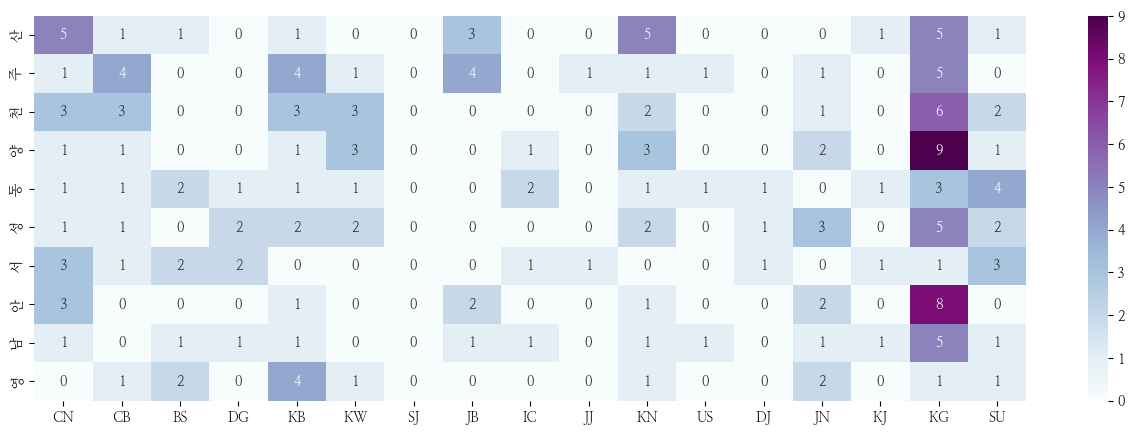

In [24]:
show_figure(most_city_df)

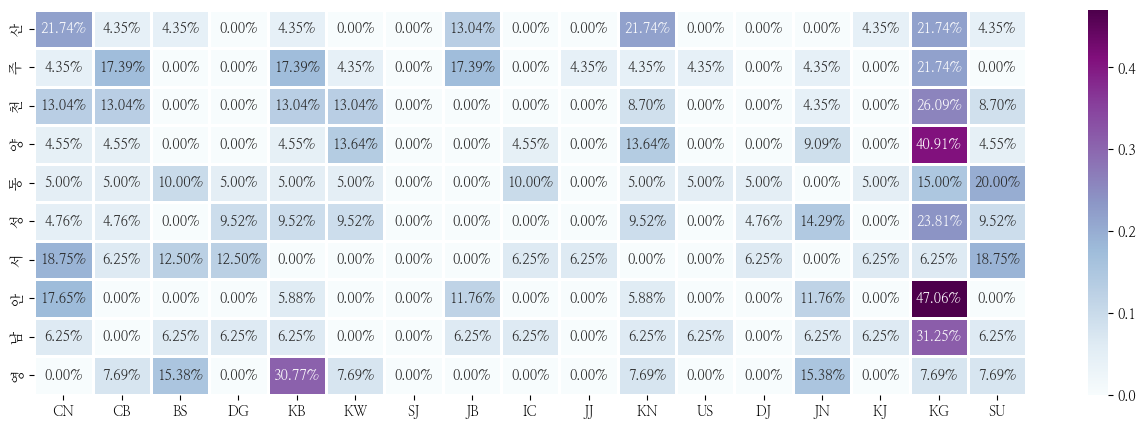

In [25]:
show_figure(most_city_df, is_percentage = True)

In [26]:
ratio, sum_cities20p, sum_citiesall = ratio_calculator(cities, cities_cnt)
f'{ratio * 100:.3f} %'

'60.271 %'

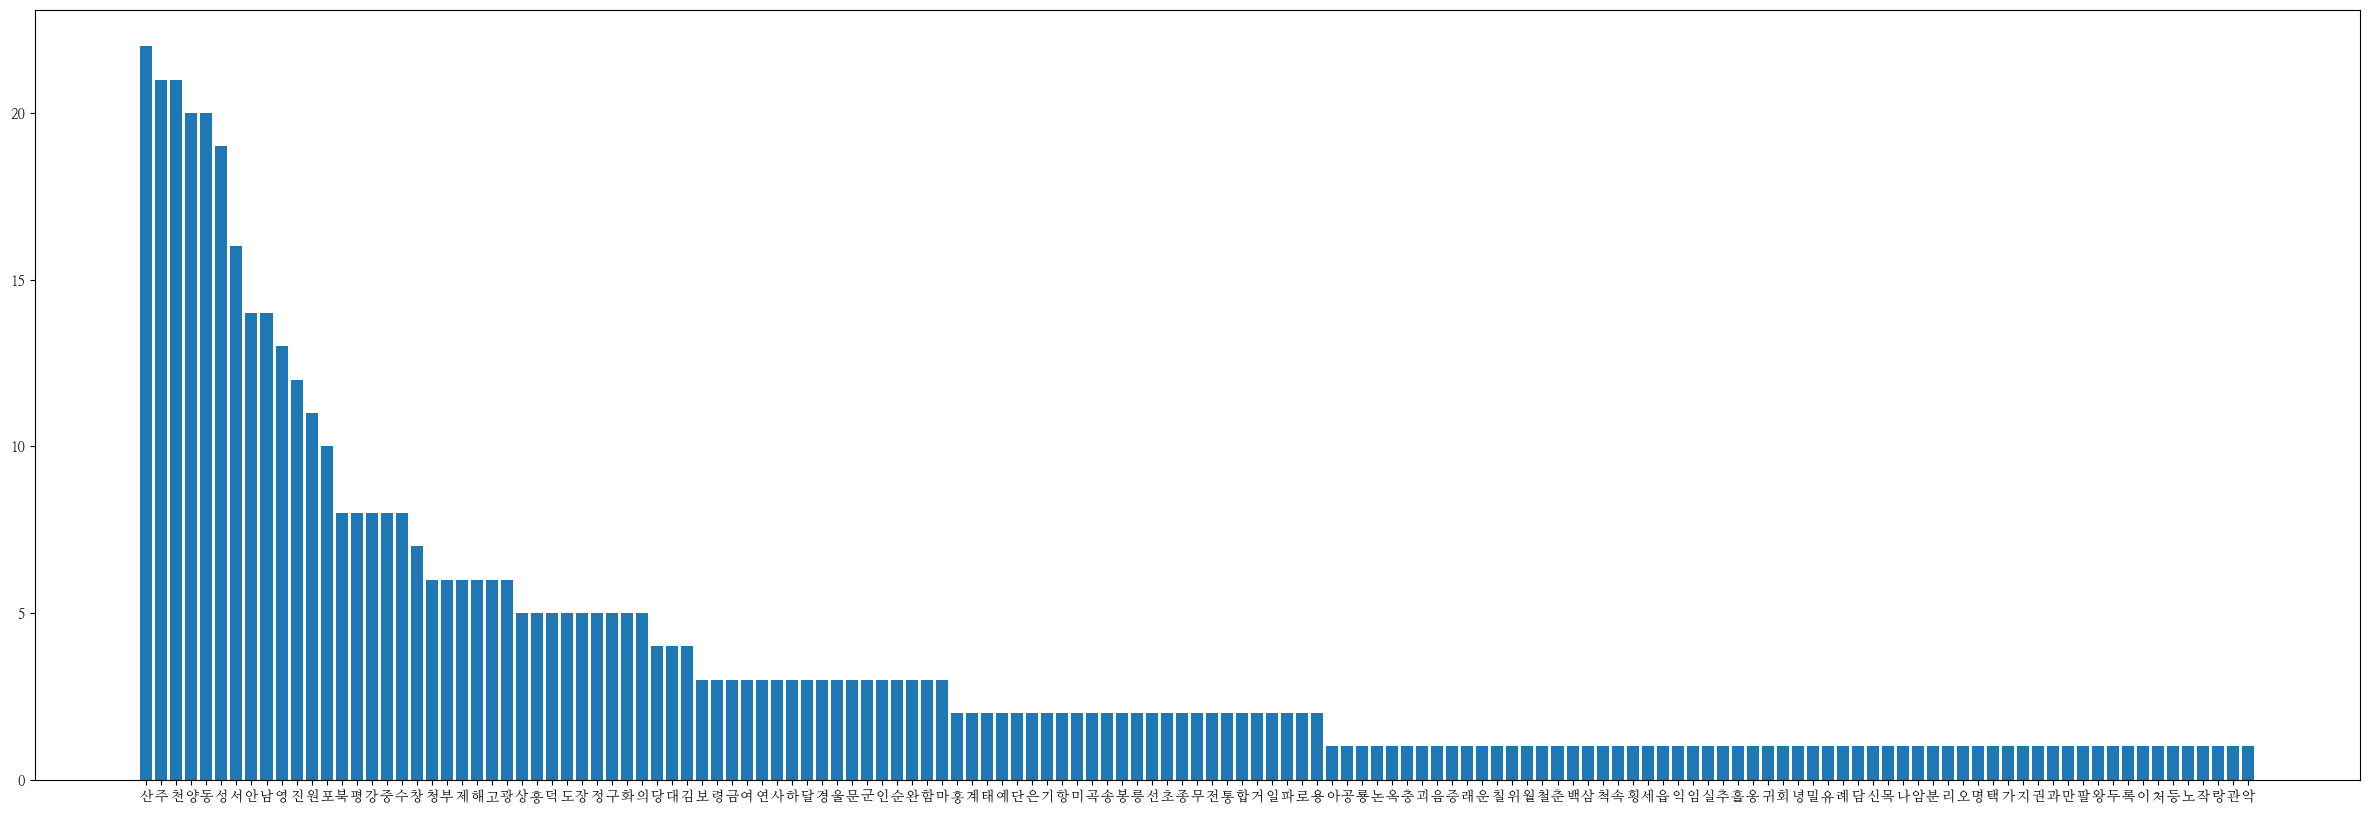

In [27]:
show_figure(cities_cnt)

In [28]:
sum_cities20p, sum_citiesall, 0.8 * sum_citiesall

(311, 516, 412.8)

In [29]:
files            = [path for path in list_files(f'{DATA_PATH}/towns') if path.split('.')[-1] == 'shp']
towns, num_towns = all_sectors(files)
town_cnt         = sorted(Counter(towns).items(), key = lambda x: x[1], reverse = True)
most_towns       = town_cnt[:10]
town_cnt         = dict(town_cnt)
num_towns, most_towns

({'SJ': 112,
  'CB': 1157,
  'JB': 1155,
  'IC': 121,
  'JJ': 117,
  'JN': 1765,
  'DG': 90,
  'KB': 2025,
  'KN': 1404,
  'KG': 1204,
  'SU': 19,
  'US': 114,
  'KW': 999,
  'BS': 62,
  'CN': 1524},
 [('산', 717),
  ('곡', 578),
  ('동', 500),
  ('천', 485),
  ('대', 473),
  ('신', 447),
  ('정', 441),
  ('성', 367),
  ('상', 354),
  ('평', 343)])

In [30]:
most_town_province = most_char_province(files, most_towns)
indexes            = [t[0] for t in most_towns] 
most_town_df       = pd.DataFrame(most_town_province, index = indexes)

most_town_df

,SJ,CB,JB,IC,JJ,JN,DG,KB,KN,KG,SU,US,KW,BS,CN
산,11,64,87,10,8,114,8,105,89,68,0,8,51,3,91
곡,11,68,45,0,0,68,9,114,78,56,0,5,53,3,68
동,2,51,51,4,5,109,2,60,52,44,0,6,44,4,66
천,2,41,39,1,7,64,8,89,54,40,5,13,56,6,60
대,6,49,45,3,5,55,5,70,61,46,2,8,42,2,74
신,6,42,54,7,11,52,2,73,37,55,2,3,22,2,79
정,6,45,45,7,1,70,3,58,56,40,1,4,33,1,71
성,6,44,40,4,8,61,2,63,35,26,0,1,15,2,60
상,1,36,34,5,8,47,2,69,38,32,0,4,43,0,35
평,2,45,29,2,5,53,2,57,47,31,0,3,26,3,38


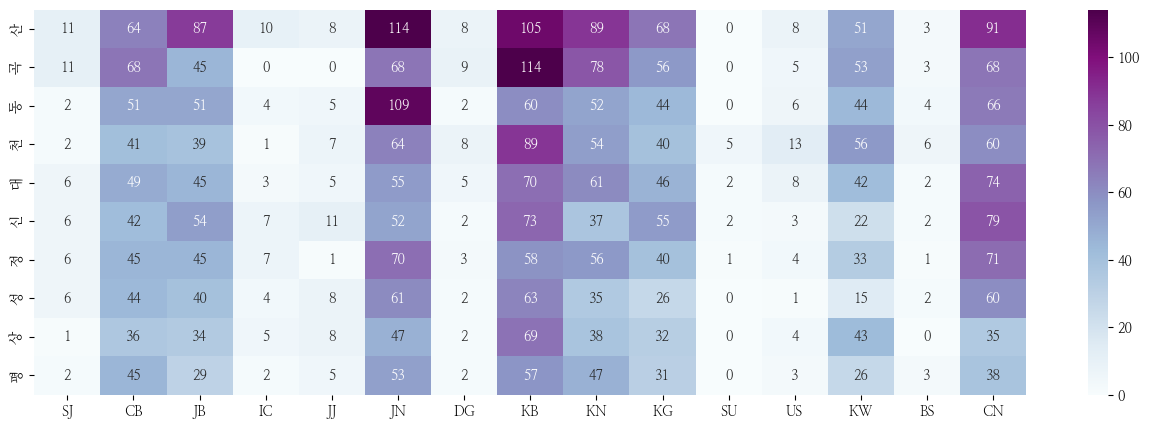

In [31]:
show_figure(most_town_df)

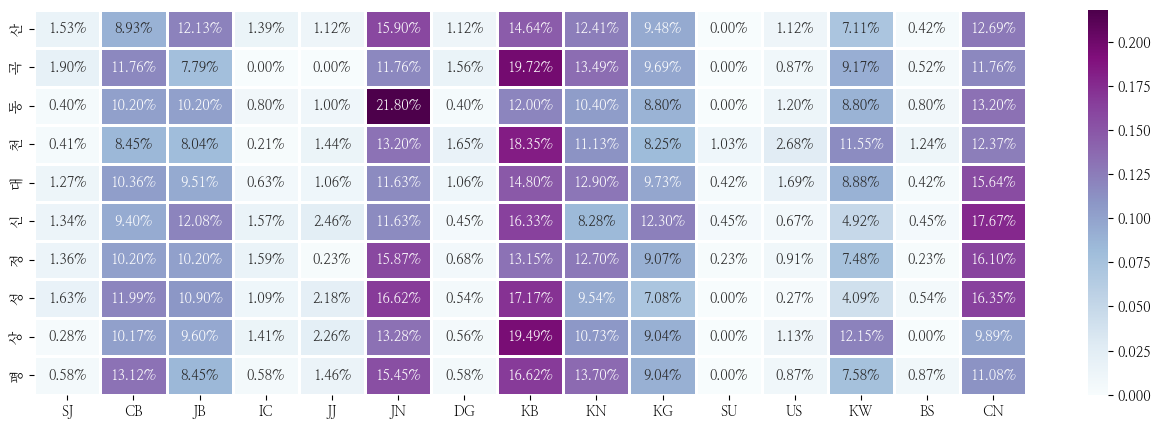

In [32]:
show_figure(most_town_df, is_percentage = True)

In [33]:
ratio, sum_town20p, sum_townall = ratio_calculator(towns, town_cnt)
f'{ratio * 100:.3f} %'

'73.254 %'

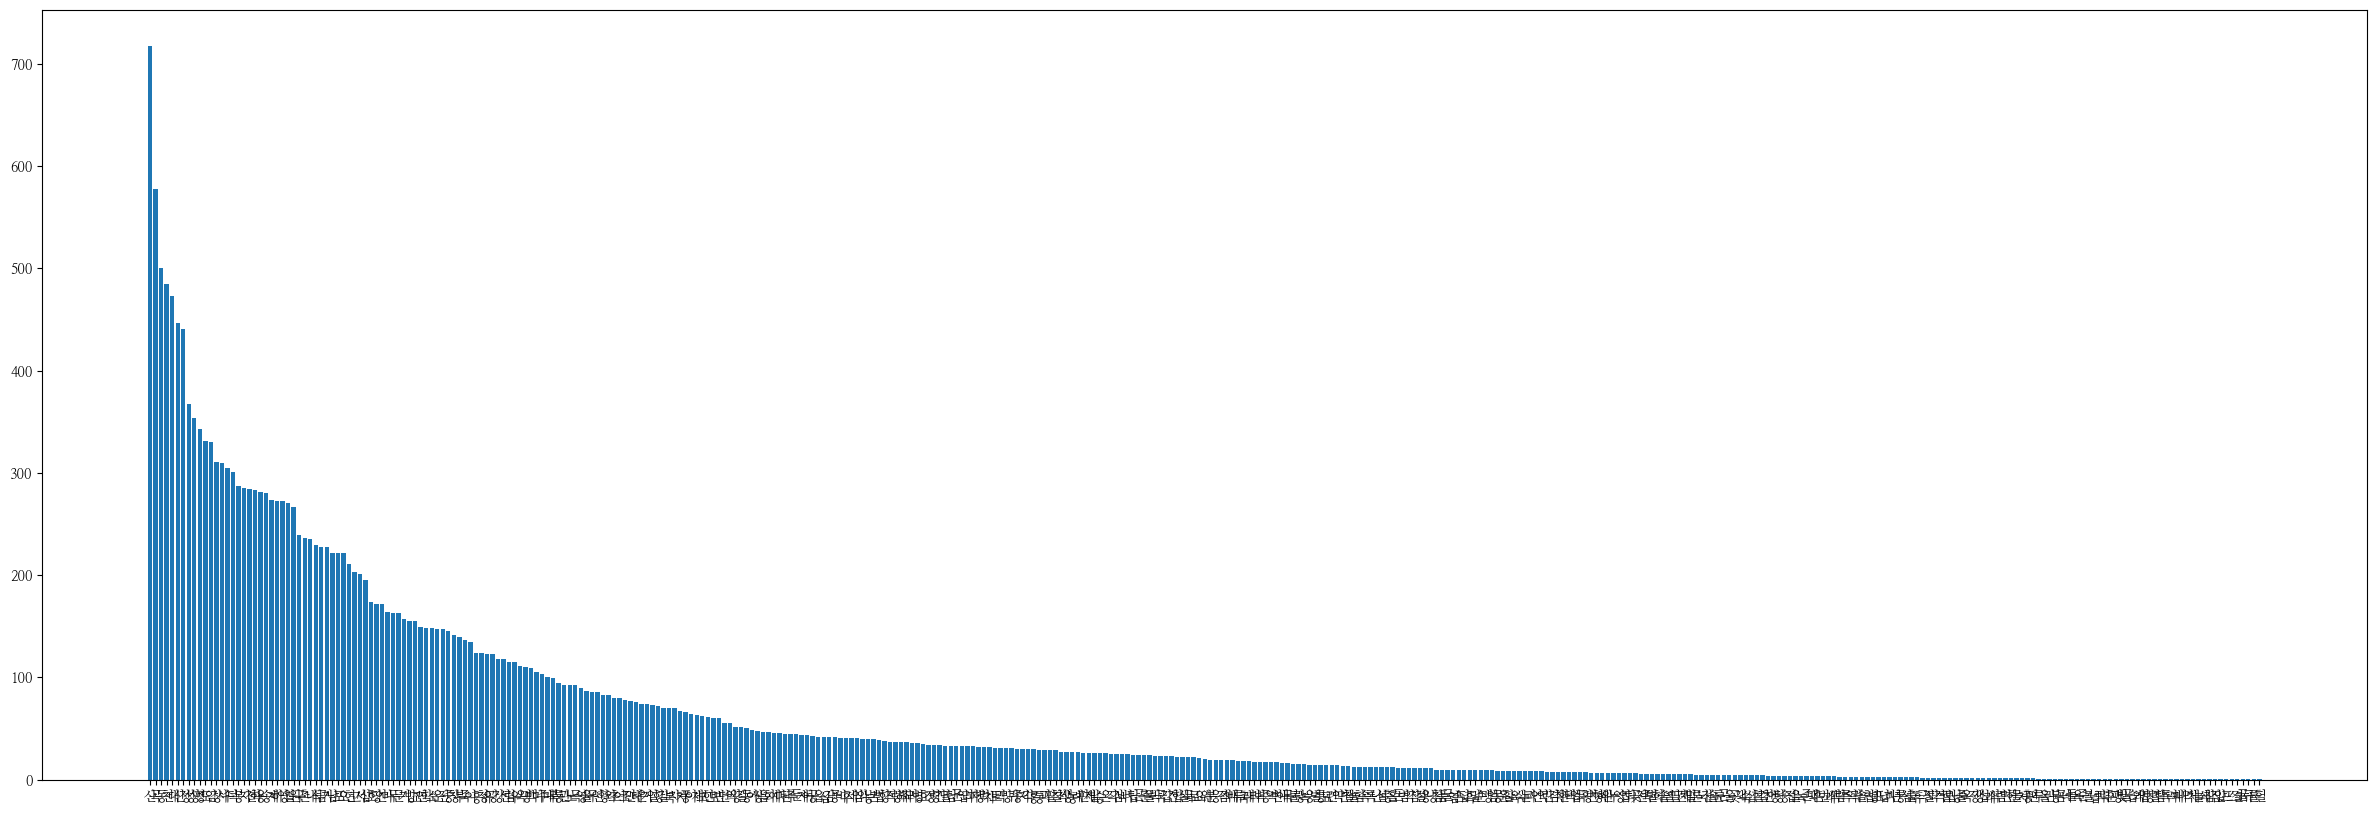

In [34]:
show_figure(town_cnt)

In [35]:
sum_town20p, sum_townall, 0.8 * sum_townall

(17321, 23645, 18916.0)